In [37]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import numpy as np
import networkx as nx
#### 00 read data
data_routes = gpd.read_file("../dat/geo-strecke/strecken_polyline.shp")
gdf_routes = gpd.GeoDataFrame(data_routes, geometry = 'geometry')


In [38]:
# import os
# path = "/Users/jihakim/Documents/GitHub/db_project/exp"
# os.getcwd()
# os.chdir(path)


In [39]:
data_rides = pd.read_csv("../dat/Zugfahrten_2016_12.csv", sep=";",  encoding='latin-1', date_parser="PROD_DATUM")
data_rides.columns = ["Station or stop", "Country", "Date", "Number of train rides", "Minutes of delay"]
data_rides = data_rides.sort_values(["Station or stop","Date"])

data_stations = pd.read_csv("../dat/GEO_Bahnstellen_EXPORT.csv", sep = ";", encoding = "latin-1")
data_stations.columns = ["Station or stop", "Name", "Country", "Coordinate Latitude", "Coordinate Longitude"]
data_stations = data_stations.sort_values(["Station or stop"])
# merge the two dataframes

data = pd.merge(data_rides, data_stations, on = "Station or stop")
data = data.drop(["Country_x"], axis = 1)
#data = data[data["Date"] != pd.to_datetime("2016-10-26")]
data["MeanOfDelay"] = data["Minutes of delay"] / data["Number of train rides"]
data["Delay"] = np.where(data["MeanOfDelay"]>6,1,0)


# allzero_station = station_data[station_data['sum of delay'] ==0]['Station or stop'].tolist()
# data = data[~ data['Station or stop'].isin(allzero_station)]
data = data.groupby(["Station or stop","Name", "Coordinate Latitude","Coordinate Longitude"]).mean().reset_index()
data = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data["Coordinate Longitude"], data["Coordinate Latitude"]))

gdf_stations = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data["Coordinate Longitude"], data["Coordinate Latitude"]))

# rename the column "Country_y" to "Country"
data = data.rename(columns = {"Country_y": "Country"})
# gdf_stations = gdf_stations.to_crs({'init': 'epsg:4326'} )

/var/folders/6d/6k3gy8t558517t4dg0xy4nlm0000gn/T/ipykernel_82707/1769333498.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(["Station or stop","Name", "Coordinate Latitude","Coordinate Longitude"]).mean().reset_index()


In [40]:
data1 = data.copy()

In [41]:
data = pd.merge(data_routes.assign(key=1), gdf_stations.assign(key=1), on='key').drop('key', 1)

/var/folders/6d/6k3gy8t558517t4dg0xy4nlm0000gn/T/ipykernel_82707/94818313.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = pd.merge(data_routes.assign(key=1), gdf_stations.assign(key=1), on='key').drop('key', 1)


In [42]:
data['distance'] = data['geometry_x'].distance(data['geometry_y'])
data = data[data["distance"] < 0.01] 

/var/folders/6d/6k3gy8t558517t4dg0xy4nlm0000gn/T/ipykernel_82707/2794062191.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data['distance'] = data['geometry_x'].distance(data['geometry_y'])
/var/folders/6d/6k3gy8t558517t4dg0xy4nlm0000gn/T/ipykernel_82707/2794062191.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  data['distance'] = data['geometry_x'].distance(data['geometry_y'])


In [43]:
stations = data.groupby(["strecke_nr","Station or stop","Name","geometry_y"])[["Number of train rides", "Minutes of delay","MeanOfDelay"]].mean().reset_index()

In [44]:
stations.columns = ['strecke_nr', 'Station or stop', 'Name', 'geometry',
       'Number of train rides', 'Minutes of delay',"MeanOfDelay"]

In [45]:
#data = pd.merge(stations, gdf_stations, on="strecke_nr")
data = pd.merge(stations.assign(key=1), stations.assign(key=1), on='key').drop('key', 1)

/var/folders/6d/6k3gy8t558517t4dg0xy4nlm0000gn/T/ipykernel_82707/1505208447.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = pd.merge(stations.assign(key=1), stations.assign(key=1), on='key').drop('key', 1)


In [46]:
data = data[ (data["strecke_nr_x"]==data["strecke_nr_y"] ) &  # same strecke 
            (data["Station or stop_x"]!=data["Station or stop_y"])].reset_index(drop=True)
inter_data = data[(data["Station or stop_x"]==data["Station or stop_y"]) & #conisder transfer
                  (data["strecke_nr_x"]==data["strecke_nr_y"])]
data = gpd.GeoDataFrame(data, geometry="geometry_x")
data["distance"] = data["geometry_x"].distance(data['geometry_y'])

data['rank'] = data.groupby(['strecke_nr_x', 'Station or stop_x', 'Name_x', 'geometry_x'])['distance'].rank()

# 2 = left and right of the station
min_indices = data[data['rank'] == 1].index
second_min_indices = data[data['rank'] == 2].index

data = pd.concat([data.iloc[min_indices ,:] , data.iloc[second_min_indices,:]], axis=0)

data = pd.concat([data, inter_data],axis=0).reset_index(drop=True)
data = gpd.GeoDataFrame(data, geometry="geometry_x")


In [47]:
data.columns
data = data[['Station or stop_x', 'Name_x','geometry_x', 'Station or stop_y', 'Name_y', 'geometry_y',
     'Number of train rides_y','Minutes of delay_y','MeanOfDelay_y']].drop_duplicates().sort_values("Station or stop_x").reset_index(drop=True)

In [48]:
# [i for i in inter_data.Name_x if "STUTT" in i]
# 'STUTTGART HBF',
# 'FRANKFURT AM MAIN STADION'
# data[data["Name_x"] == 'FRANKFURT (MAIN) AUSSENBAHNHOF']
# data[['strecke_nr_x', 'Station or stop_x', 'Name_x', 'geometry_x',
#        'Number of train rides_x', 'Minutes of delay_x', 'strecke_nr_y',
#        'Station or stop_y', 'Name_y', 'geometry_y', 'Number of train rides_y',
#        'Minutes of delay_y']].drop_duplicates()

In [60]:
# shortest path in terms of distance 
# G = nx.from_pandas_edgelist(data, source = "Name_x" , target = "Name_y" ,edge_attr="MeanOfDelay_y")
# shortest_paths = nx.all_shortest_paths(G, source='STUTTGART HBF',
#                                        target='FRANKFURT AM MAIN STADION',
#                                       weight='distance')


# paths = pd.DataFrame({"path":[]})
# for path in shortest_paths:
#     path = pd.DataFrame({"path":path})
#     paths = pd.concat([paths, path], axis=1)
# # 16 paths in total 
# paths = paths.T.reset_index(drop=True)
# paths =paths.drop_duplicates()
# paths = paths.dropna()
# paths = paths.T
# paths.columns = [f"path{i}" for i in paths.columns.tolist()]
# paths[["path1"]]
# # just select one path 
# shortest = pd.merge(paths[["path1"]], data1, left_on= "path1", right_on="Name")
# shortest["CumulativeDelay"] = shortest["MeanOfDelay"].cumsum(axis=0)
# shortest

In [57]:
# # Fastest route that Deutsche Bahn offers
fastest_route = [80290346,80290338,80290387, # added 
                 80290288,  # Stuttgart
                 80290270, 80297853, 80297846,
                 80196212, 80297788, 80297770, 80145615,
                 80142620, 80183079, 80142786, 80142877,
                 80145649, 80144147, 80140640, 80180919,
                 80140624, 80140616, 80147124, 80182576, 80042408,
                 80143909, 80140236, 80140137,  # Mannheim
                 80140186, 80113324, 80113316, 80113308,
                 80113118, 80113092, 80113084,
                 80113076, 80104711, 80113043, 80113035, 80112995, 80112987, 80105767, 80112953, 80113365,  # Darmstadt
                 80112813, 80112839, 80112854, 80105098, 80108555, 80107995  # Frankfurt Main
                 ]

shortest = data1[data1["Station or stop"].isin(fastest_route)]

data1
shortest = pd.merge(paths[["path1"]], data1, left_on= "path1", right_on="Name")
shortest["CumulativeDelay"] = shortest["MeanOfDelay"].cumsum(axis=0)
shortest

,path1,Station or stop,Name,Coordinate Latitude,Coordinate Longitude,Number of train rides,Minutes of delay,MeanOfDelay,Delay,geometry,CumulativeDelay
0,STUTTGART HBF,80290346,STUTTGART HBF,48.785200,9.193238,11.200000,9.800000,0.872424,0.000000,POINT (9.19324 48.78520),0.872424
1,STUTTGART NORDBAHNHOF,80290338,STUTTGART NORDBAHNHOF,48.804580,9.186535,11.428571,6.000000,0.494372,0.000000,POINT (9.18653 48.80458),1.366797
2,STUTTGART-ZUFFENHAUSEN,80290387,STUTTGART-ZUFFENHAUSEN,48.830536,9.168231,10.535714,4.750000,0.336402,0.017857,POINT (9.16823 48.83054),1.703198
3,GLEMS,80297846,GLEMS,48.892043,9.073629,10.536585,10.609756,1.042868,0.048780,POINT (9.07363 48.89204),2.746066
4,VAIHINGEN (ENZ),80196212,VAIHINGEN (ENZ),48.947902,8.959384,57.357595,34.892405,0.534253,0.003165,POINT (8.95938 48.94790),3.280320
5,STERNENFELS METTERTAL,80297788,STERNENFELS METTERTAL,49.003449,8.875093,15.618090,3.125628,0.196929,0.000000,POINT (8.87509 49.00345),3.477249
6,FREUDENSTEIN,80297770,FREUDENSTEIN,49.038059,8.806269,15.675000,3.315000,0.216405,0.005000,POINT (8.80627 49.03806),3.693654
7,KRAICHTAL,80145615,KRAICHTAL,49.090590,8.733470,15.845771,13.213930,0.818624,0.014925,POINT (8.73347 49.09059),4.512278
8,EISENHUT,80142620,EISENHUT,49.130986,8.641517,15.583756,2.167513,0.127245,0.000000,POINT (8.64152 49.13099),4.639523
9,FORST,80142786,FORST,49.167870,8.571355,13.885057,2.051724,0.147135,0.000000,POINT (8.57136 49.16787),4.786657


In [50]:
# 'STUTTGART HBF',
# 'FRANKFURT AM MAIN STADION'

G_reliable_paths = nx.all_shortest_paths(G, source='STUTTGART HBF',
                                       target='FRANKFURT AM MAIN STADION',
                                       weight="MeanOfDelay_y")

reliable_paths = pd.DataFrame({"path":[]})

for path in G_reliable_paths:
    path = pd.DataFrame({"path":path})
    reliable_paths = pd.concat([reliable_paths, path], axis=1)
 


In [51]:

reliable_paths = reliable_paths.T.reset_index(drop=True)
reliable_paths =reliable_paths.drop_duplicates()
reliable_paths = reliable_paths.dropna()
reliable_paths = reliable_paths.T
reliable_paths.columns = ["reliable_path1"]
reliable_paths[["reliable_path1"]]
# just select one path 
reliable = pd.merge(reliable_paths[["reliable_path1"]], data1, left_on= "reliable_path1", right_on="Name")
reliable["CumulativeDelay"] = reliable["MeanOfDelay"].cumsum(axis=0)
reliable.head(2)

,reliable_path1,Station or stop,Name,Coordinate Latitude,Coordinate Longitude,Number of train rides,Minutes of delay,MeanOfDelay,Delay,geometry,CumulativeDelay
0,STUTTGART HBF,80290346,STUTTGART HBF,48.785200,9.193238,11.200000,9.800000,0.872424,0.000000,POINT (9.19324 48.78520),0.872424
1,STUTTGART-FEUERBACH,80290312,STUTTGART-FEUERBACH,48.814222,9.169317,12.250000,0.000000,0.000000,0.000000,POINT (9.16932 48.81422),0.872424
2,STUTTGART-ZUFFENHAUSEN,80290387,STUTTGART-ZUFFENHAUSEN,48.830536,9.168231,10.535714,4.750000,0.336402,0.017857,POINT (9.16823 48.83054),1.208826
3,GLEMS,80297846,GLEMS,48.892043,9.073629,10.536585,10.609756,1.042868,0.048780,POINT (9.07363 48.89204),2.251694
4,VAIHINGEN (ENZ),80196212,VAIHINGEN (ENZ),48.947902,8.959384,57.357595,34.892405,0.534253,0.003165,POINT (8.95938 48.94790),2.785947
5,STERNENFELS METTERTAL,80297788,STERNENFELS METTERTAL,49.003449,8.875093,15.618090,3.125628,0.196929,0.000000,POINT (8.87509 49.00345),2.982877
6,FREUDENSTEIN,80297770,FREUDENSTEIN,49.038059,8.806269,15.675000,3.315000,0.216405,0.005000,POINT (8.80627 49.03806),3.199282
7,KRAICHTAL,80145615,KRAICHTAL,49.090590,8.733470,15.845771,13.213930,0.818624,0.014925,POINT (8.73347 49.09059),4.017906
8,EISENHUT,80142620,EISENHUT,49.130986,8.641517,15.583756,2.167513,0.127245,0.000000,POINT (8.64152 49.13099),4.145151
9,FORST,80142786,FORST,49.167870,8.571355,13.885057,2.051724,0.147135,0.000000,POINT (8.57136 49.16787),4.292285


In [53]:
# path1 = pd.merge(paths, data, left_on= "path1", right_on="Name")
# path1["MeanOfDelay"].sum()

# path3 = pd.merge(paths, data, left_on= "path3", right_on="Name")
# path3["MeanOfDelay"].sum()

In [58]:
from tueplots import bundles
from tueplots.constants.color import rgb
from matplotlib import ticker
import matplotlib.pyplot as plt
# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 150})
# set plotting stylesheet
plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
shortest = gpd.GeoDataFrame(shortest, geometry = 'geometry')
reliable = gpd.GeoDataFrame(reliable, geometry = 'geometry')



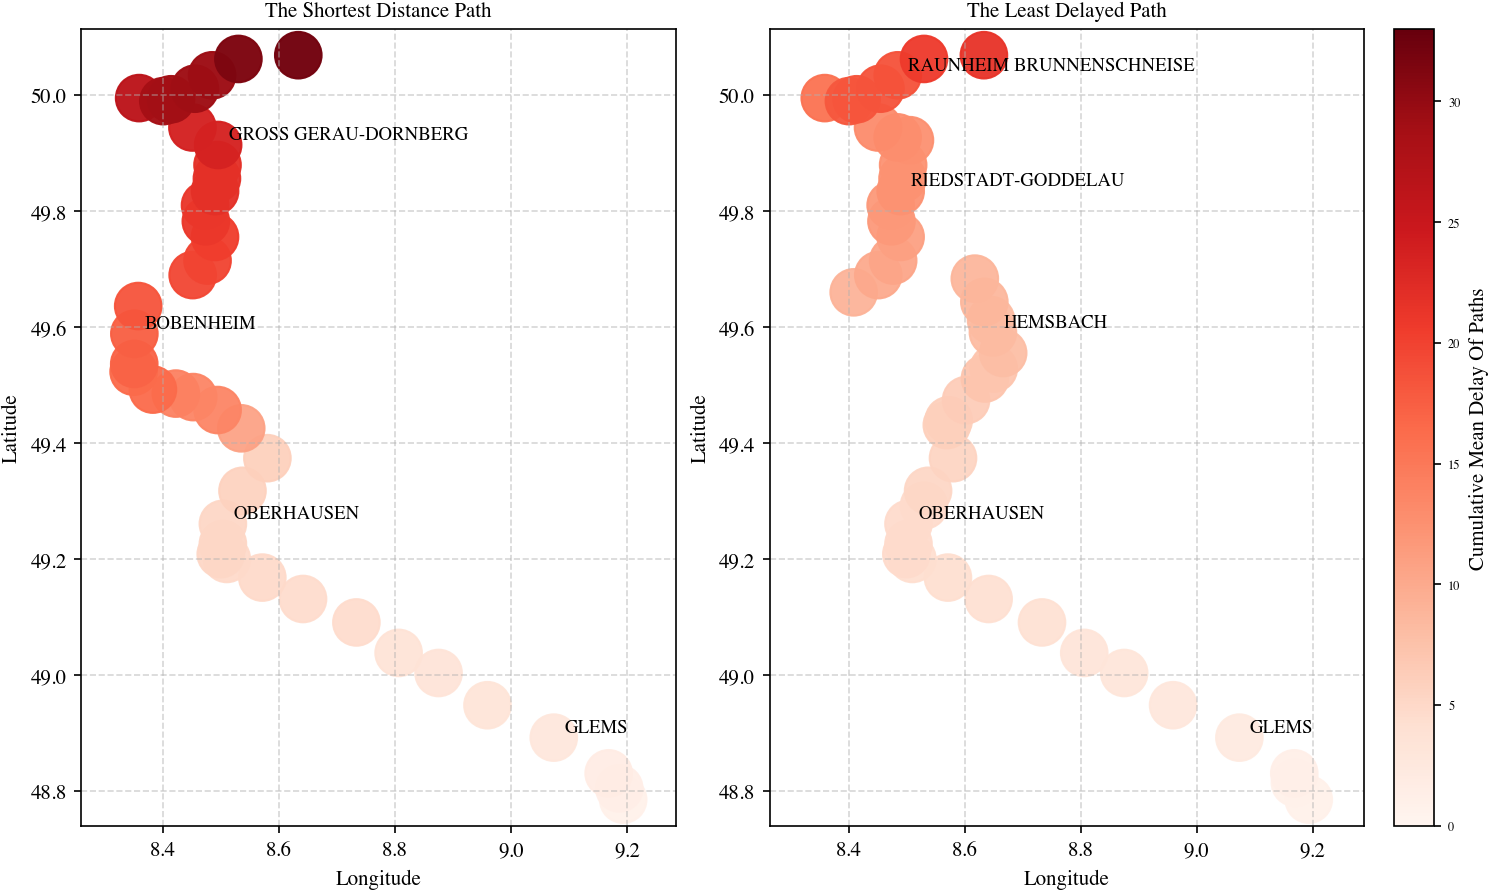

In [59]:
from tueplots import bundles
from tueplots.constants.color import rgb
from matplotlib import ticker
import matplotlib.pyplot as plt


def assign_colors(values):
    cmap = plt.get_cmap("Reds")  # 색상 맵 선택
    norm = plt.Normalize(0, 33)  # 정규화

    # ScalarMappable을 사용하여 색상 맵 적용
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # 색상 지정
    colors = cmap(norm(values))
    return colors, sm

# 데이터프레임에서 'CumulativeDelay'에 따라 색상 지정
colors_shortest, sm_shortest = assign_colors(shortest['CumulativeDelay'])
colors_reliable, sm_reliable = assign_colors(reliable['CumulativeDelay'])

# 그래프 구성
fig, ax = plt.subplots(1, 2, figsize=(10, 6))




# 첫 번째 subplot (shortest 그래프)
shortest.loc[:, "geometry"].plot(ax=ax[0],
    linewidth=1,
    alpha= np.log1p(shortest["CumulativeDelay"]+100)/5,
    color=colors_shortest, 
    marker='o',
    markersize=500)

# 두 번째 subplot (reliable 그래프)
reliable.loc[:, "geometry"].plot(ax=ax[1],
    linewidth=1,
    alpha=np.log1p(reliable["CumulativeDelay"]+100)/5,
    color=colors_reliable,
    marker='o',
    markersize=500)



for idx, row in shortest.iterrows():
    if idx % 10 == 3:
        ax[0].annotate("{}".format(row["Name"]),
                       xy=(row["geometry"].x, row["geometry"].y),
                       xytext=(5, 5),
                       textcoords='offset points',
                       size=9,

                       color="black",
                       ha='left', va='center')


for idx, row in reliable.iterrows():
    if idx % 10 == 3:
        ax[1].annotate("{}".format(row["Name"]),
                       xy=(row["geometry"].x, row["geometry"].y),
                       xytext=(5, 5),
                       textcoords='offset points',
                       size=9,
                       color="black",
                       ha='left', va='center')
        
ax[0].set_title("The Shortest Distance Path(Deutsche Bahn)", fontsize=10)
ax[1].set_title("The Least Delayed Path", fontsize=10)


ax[0].set_xlabel("Longitude", fontsize=10)
ax[0].set_ylabel("Latitude", fontsize=10)

ax[1].set_xlabel("Longitude", fontsize=10)
ax[1].set_ylabel("Latitude", fontsize=10)

ax[0].grid(True, linestyle='--', alpha=0.5)
ax[1].grid(True, linestyle='--', alpha=0.5)


ax[0].tick_params(axis='both', which='both', labelsize=10)
ax[1].tick_params(axis='both', which='both', labelsize=10)


ax[0].axis('equal')
ax[1].axis('equal')


#cbar_shortest = plt.colorbar(sm_shortest, ax=ax[0])
#cbar_shortest.set_label('CumulativeDelay (Shortest)')

cbar_reliable = plt.colorbar(sm_reliable, ax=ax[1])
cbar_reliable.set_label('Cumulative Mean Delay Of Paths', size=10)

plt.savefig('../doc/fig/maps_JH_02_compare_paths.pdf', format='pdf', bbox_inches='tight')
plt.savefig('../doc/fig/maps_JH_02_compare_paths.png', dpi=300)
plt.show()

plt.show()


In [30]:
# # Fastest route that Deutsche Bahn offers
# fastest_route = [80290346,80290338,80290387, # added 
#                  80290288,  # Stuttgart
#                  80290270, 80297853, 80297846,
#                  80196212, 80297788, 80297770, 80145615,
#                  80142620, 80183079, 80142786, 80142877,
#                  80145649, 80144147, 80140640, 80180919,
#                  80140624, 80140616, 80147124, 80182576, 80042408,
#                  80143909, 80140236, 80140137,  # Mannheim
#                  80140186, 80113324, 80113316, 80113308,
#                  80113118, 80113092, 80113084,
#                  80113076, 80104711, 80113043, 80113035, 80112995, 80112987, 80105767, 80112953, 80113365,  # Darmstadt
#                  80112813, 80112839, 80112854, 80105098, 80108555, 80107995  # Frankfurt Main
#                  ]

# fastest = data[data["Station or stop"].isin(fastest_route)]
# fastest